# CSCK506 Deep Learning Group Project
To train a *Convolutional Neural Network* (CNN) model to be able to detect healthy lungs from pneumonia infected ones.

Table of Contents
=================
1. [Import Libraries](#Import-Libraries)
2. [Data Preprocessing](#Data-Preprocessing)
    1. [Load Data](#Load-Data)
    2. [Understanding the Data](#Understanding-the-Data)
    3. [Data Visualization](#Data-Visualization)
    4. [Check for Imbalance Data](#Check-for-Imbalance-Data)
    5. [Data Augmentation](#Data-Augmentation)
    6. [Dataloader for Batching](#Dataloader-for-Batching)
 3. [Model Development](#Model-Development)
    1. [Build the CNN Model](#Build-the-CNN-Model)
    2. [Train the CNN Model](#Train-the-CNN-Model)
    3. [Evaluate the CNN Model](#Evaluate-the-CNN-Model)
    4. [Save the CNN Model](#Save-the-CNN-Model)
 4. [Model Testing](#Model-Testing)
    1. [Load the CNN Model](#Load-the-CNN-Model)
    2. [Test the CNN Model](#Test-the-CNN-Model)

## Import Libraries

In [1]:
import os
import hashlib
import zipfile
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.1


In [2]:
# Test GPU availability
if tf.test.gpu_device_name() == '/device:GPU:0':
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

## Data Preprocessing

### Unzip File into data folder
- Download the dataset from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and extract it to the same directory as this notebook.
- To re-extract the dataset, delete the data folder and run the following code.

In [3]:
if not os.path.exists('data'):
    DATA_EXIST = False
    os.makedirs('data')
else:
    DATA_EXIST = True
    EXTRACT_FROM_ZIP = False
    print('Data folder already exists')

# Check if downloaded data is correct
FILENAME = 'archive.zip'
SHA256SUM ='f569fe885b0f921e836f3d6bcc8d7b3442f5e0ca4db4533d06b8cf25d2114ea1'

if os.path.exists(FILENAME) and not DATA_EXIST:
    with open(FILENAME, 'rb') as f:
        read_bytes = f.read() # read entire file as bytes
        READABLE_HASH = hashlib.sha256(read_bytes).hexdigest()
        if READABLE_HASH != SHA256SUM:
            print('Data corrupted, please download again')
            os.remove(FILENAME)
            EXTRACT_FROM_ZIP = False
        else:
            EXTRACT_FROM_ZIP = True # Ready to extract data from zip file

folder_to_extract = ['chest_xray/test', 'chest_xray/train', 'chest_xray/val']

# Extract data from zip file
if not DATA_EXIST and EXTRACT_FROM_ZIP:
    with zipfile.ZipFile(FILENAME, 'r') as zip_ref:
        for fol in folder_to_extract:
            for file in zip_ref.namelist():
                if file.startswith(fol):
                    zip_ref.extract(file, 'data')
    for fol in folder_to_extract:
        os.rename('data/'+fol, 'data/'+fol.split('/')[1])
    os.rmdir('data/chest_xray')

Data folder already exists


### Load the Data

In [4]:
# Set data directory
train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

# labels
labels = ['NORMAL', 'PNEUMONIA']


### Understanding the Data

In [5]:
# Plot the number of images per class in a dataset
def plot_num_images_per_class(data_dir, labels, title='Number of images per class'):
    """
    Plot the number of images per class in a dataset
    
    Args:
        data_dir: directory of the dataset
        labels: list of labels
        title: title of the plot

    Returns:
        num_images: plot of the number of images per class
        ratio: ratio of images per class
    """
    num_images = []
    ratio = {}
    print(title)
    for label in labels:
        count = len(os.listdir(os.path.join(data_dir, label)))
        num_images.append(count)
    
    print(f'Total: {sum(num_images)}')

    for i in range(len(labels)):
        ratio[labels[i]] = num_images[i]/sum(num_images)
        print(f'{labels[i]}: {num_images[i]} ({ratio[labels[i]]*100:.2f}%)')

    plt.bar(labels, num_images)
    plt.title(title)
    plt.show()
    return num_images, ratio

# Plot the number of images in each dataset
def plot_num_images_per_dataset(train_num_images, test_num_images, val_num_images):
    """
    Plot the number of images in each dataset

    Args:
        train_num_images: number of images per class in train dataset
        test_num_images: number of images per class in test dataset
        val_num_images: number of images per class in val dataset

    Returns:
        num_images: plot of the number of images in each dataset
        ratio: ratio of images in each dataset
    """
    num_images = [sum(train_num_images), sum(test_num_images), sum(val_num_images)]
    # ratio of images in each dataset
    ratio = {'train': num_images[0]/sum(num_images), 'test': num_images[1]/sum(num_images), 'val': num_images[2]/sum(num_images)}
    for i in range(3):
        print(f'{["train", "test", "val"][i]}: {num_images[i]} ({ratio[["train", "test", "val"][i]]*100:.2f}%)')
    plt.bar(['train', 'test', 'val'], num_images)
    plt.title('Number of images per dataset')
    plt.show()
    return num_images, ratio

Number of images per class in train dataset
Total: 5216
NORMAL: 1341 (25.71%)
PNEUMONIA: 3875 (74.29%)


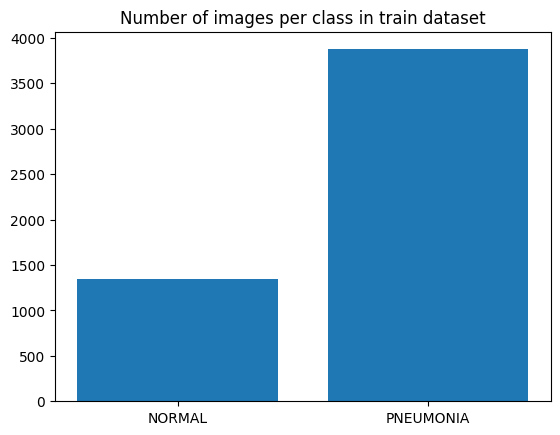

Number of images per class in test dataset
Total: 624
NORMAL: 234 (37.50%)
PNEUMONIA: 390 (62.50%)


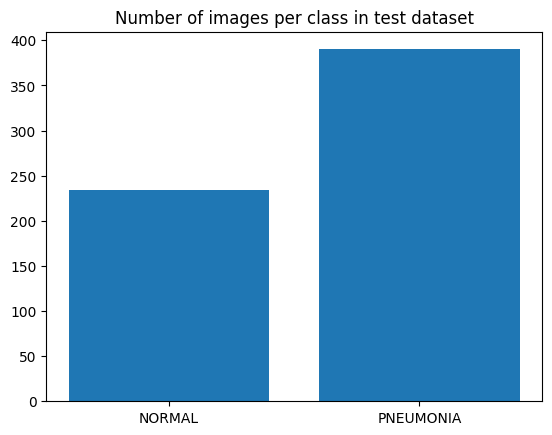

Number of images per class in val dataset
Total: 16
NORMAL: 8 (50.00%)
PNEUMONIA: 8 (50.00%)


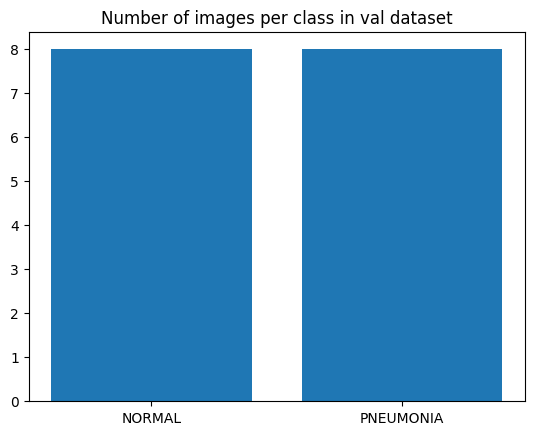

train: 5216 (89.07%)
test: 624 (10.66%)
val: 16 (0.27%)


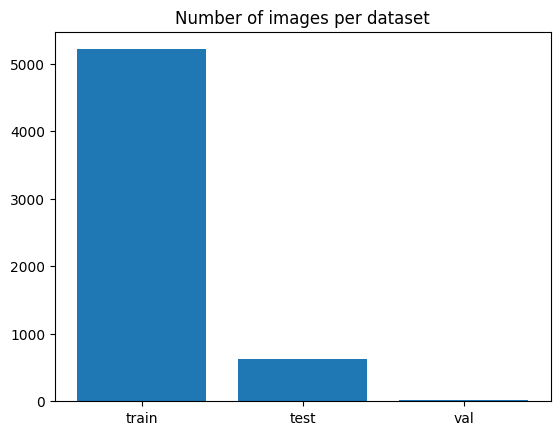

In [6]:
train_num_images, train_ratio = plot_num_images_per_class(train_dir, labels, title='Number of images per class in train dataset')
test_num_images, test_ratio = plot_num_images_per_class(test_dir, labels, title='Number of images per class in test dataset')
val_num_images, val_ratio = plot_num_images_per_class(val_dir, labels, title='Number of images per class in val dataset')
num_images, tts_ratio = plot_num_images_per_dataset(train_num_images, test_num_images, val_num_images)

### Adjust for Imbalance Data by calculating class weights
From the graph above, we can see that the data is imbalanced. To solve this problem, we will calculate the class weights and use it in the loss function.
The normal class will have a higher weight than the pneumonia class, as there are more pneumonia images than normal images.

In [7]:
normal_weight = 1/train_ratio['NORMAL']
pneumonia_weight = 1/train_ratio['PNEUMONIA']
class_weight = {0: normal_weight, 1: pneumonia_weight}
print(f'Class weight: {class_weight}')

Class weight: {0: 3.889634601043997, 1: 1.3460645161290323}


### Dataloader for Batching
Load the data into batches of images and labels using PyTorch's DataLoader class.

In [8]:
dataloader_params = {'labels': 'inferred',
                     'label_mode': 'binary',
                     'class_names': labels,
                     'color_mode': 'grayscale',
                     'batch_size': 16,
                     'image_size': (256, 256)
                     }
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, **dataloader_params)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, **dataloader_params)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir, shuffle=True, **dataloader_params)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [9]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [10]:
batch_img, batch_label = next(train_data.as_numpy_iterator())
print(f'Batch image shape: {batch_img.shape}, batch label shape: {batch_label.shape}')
batch_img.max(), batch_img.min()

Batch image shape: (16, 256, 256, 1), batch label shape: (16, 1)


(255.0, 0.0)

### Data Visualization

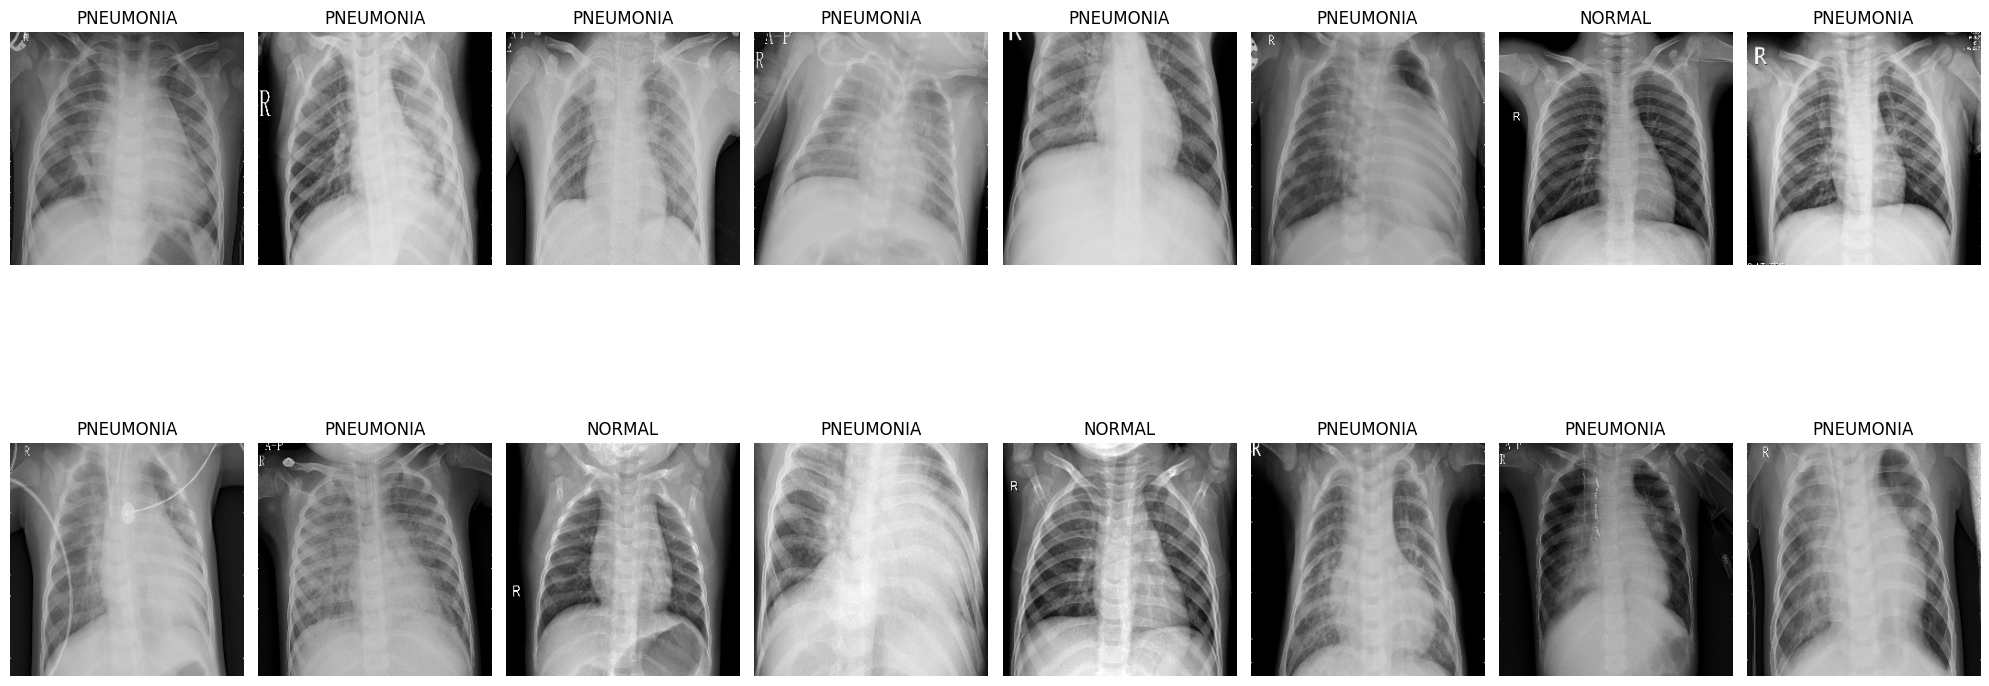

In [11]:
# Visualize batch
row, col = 2, 8
fig, axes = plt.subplots(row, col, figsize=(20, 10))
axes = axes.flatten()
for img, label, ax in zip(batch_img, batch_label, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(labels[int(label)])
    ax.axis('off')
plt.tight_layout()

### Data Normalization

In [12]:
# Rescale pixel values to [0,1] from [0,255]
print(f'Before rescaling: {batch_img.max()}, {batch_img.min()}')
train_data = train_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))
val_data = val_data.map(lambda x, y: (x/255, y))
batch_img, batch_label = next(train_data.as_numpy_iterator())
print(f'After rescaling: {batch_img.max()}, {batch_img.min()}')

Before rescaling: 255.0, 0.0
After rescaling: 1.0, 0.0


#### Data Augmentation
Alter the training data with the following transformations:
- Randomly rotate some training images by a factor of 2pi
- Randomly zoom some training images

The purpose of data augmentation is to improve the performance and ability of the model to generalize, invariant to the changes in the input data.

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation((-0.01,0.01)),
    tf.keras.layers.RandomZoom(0.1),
])
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

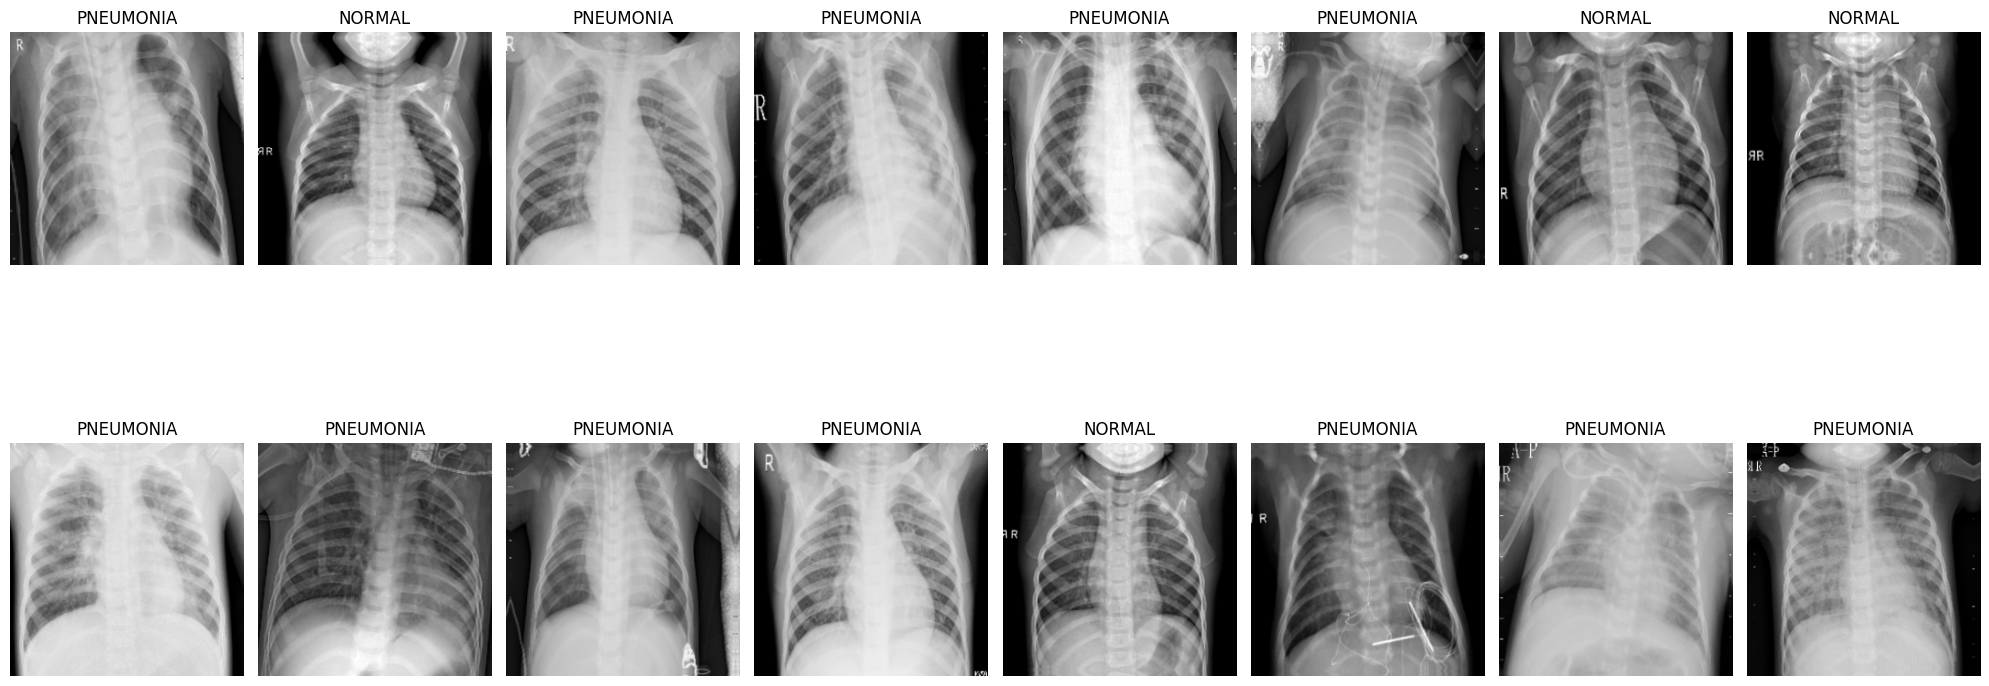

In [14]:
# Visualize batch
batch_img, batch_label = next(train_data.as_numpy_iterator())
row, col = 2, 8
fig, axes = plt.subplots(row, col, figsize=(20, 10))
axes = axes.flatten()
for img, label, ax in zip(batch_img, batch_label, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(labels[int(label)])
    ax.axis('off')
plt.tight_layout()

## Model Development

### Build the CNN Model
Use the training data to train the model with CNN which has the minimum loss and maximum accuracy for detecting the images with pneumonia.

#### Training Preparation

In [15]:
# Training optimization with autotune to determine the best number of parallel calls
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

### Train the CNN Model - **Work In Progress**
Choose:
- Number of convolution-pooling building blocks,
- The strides, padding and activation function that give you the maximum accuracy,
- A solution to avoid overfitting problem in your code. --> Regularization

In [16]:
# Create model
def create_model(input_shape, num_classes):
    """
    Create model

    Args:
        input_shape: input shape of the model
        num_classes: number of classes

    Returns:
        model: model
    """
    inputs = tf.keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)
    # Entry block
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Middle block
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Exit block
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    # Classification block
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, x)
    return model


In [17]:
# Train model with tensorboard
def train_model(model, train_data, val_data, epochs=10, class_weight=None):
    """
    Train model

    Args:
        model: model
        train_data: training data
        val_data: validation data
        epochs: number of epochs
        class_weight: class weight

    Returns:
        history: training history
    """
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    log_dir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        class_weight=class_weight,
                        callbacks=[tensorboard_callback])
    return history

### Evaluate and Tune the CNN Model
Use validation dataset to tune the hyperparameters.

#### Confusion Matrix

### Save the CNN Model

## Model Testing

### Load the CNN Model

### Test the CNN Model
Use the test dataset after the final tuning to obtain the maximum test accuracy